In [1]:
!pip install -qqq ml-collections

In [2]:
import os
os.chdir("..")

if not os.path.exists("results"):
    os.mkdir("results")

In [3]:
import jax
import ml_collections

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import glob
from datetime import datetime

import experiments.movielens_exp as movielens_run
import experiments.mnist_exp as mnist_run
import experiments.tabular_exp as tabular_run
import experiments.tabular_subspace_exp as tabular_sub_run

%load_ext autoreload
%autoreload 2

print(jax.device_count())

INFO:absl:Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO:absl:Unable to initialize backend 'gpu': NOT_FOUND: Could not find registered platform with name: "cuda". Available platform names are: Interpreter Host TPU


8


# Run tabular experiments

In [4]:
def get_config(filepath):
  """Get the default hyperparameter configuration."""
  config = ml_collections.ConfigDict()
  config.filepath = filepath
  #bandits/results/tabular_results.csv
  config.ntrials = 10
  return config

In [6]:
tabular_filename = f"./results/tabular_results_{datetime.timestamp(datetime.now())}.csv"
config = get_config(tabular_filename)
tabular_run.main(config)

Environment :  shuttle
	Bandit : Linear
		Expected Reward : 4426.40 ± 9.98
		Time : 8.391s
	Bandit : Linear KF
		Expected Reward : 4426.50 ± 12.08
		Time : 6.043s
	Bandit : Linear Wide
		Expected Reward : 4208.80 ± 7.95
		Time : 11.995s
	Bandit : Limited Neural Linear
		Expected Reward : 3864.80 ± 17.77
		Time : 17.298s
	Bandit : Unlimited Neural Linear
		Expected Reward : 4150.40 ± 16.27
		Time : 17.494s
	Bandit : EKF Subspace SVD
		Expected Reward : 4595.60 ± 164.23
		Time : 17.698s
	Bandit : EKF Subspace RND
		Expected Reward : 4846.50 ± 2.06
		Time : 17.170s
	Bandit : EKF Diagonal Subspace SVD
		Expected Reward : 4833.00 ± 0.00
		Time : 1.863s
	Bandit : EKF Diagonal Subspace RND
		Expected Reward : 4783.00 ± 0.00
		Time : 1.764s
	Bandit : EKF Orig Diagonal
		Expected Reward : 3594.20 ± 950.41
		Time : 2.011s
	Bandit : EKF Orig Full
		Expected Reward : 3912.10 ± 6.22
		Time : 42.153s
Environment :  covertype
	Bandit : Linear
		Expected Reward : 3024.80 ± 15.75
		Time : 16.138s
	Band

# Plot results

In [7]:
def plot_figure(data, x, y, filename=None, figsize=(24, 9), log_scale=False):   
    sns.set(font_scale=1.5)
    plt.style.use("seaborn-poster")

    fig, ax = plt.subplots(figsize=figsize, dpi=300)
    g = sns.barplot(x=x, y=y, hue="Method", data=data, errwidth=2, ax=ax, palette=colors)
    if log_scale:
        g.set_yscale("log")
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename)
    plt.show()

In [8]:
def read_data(dataset_name, results_filename):
    #df = pd.read_csv(f"bandits/results/{dataset_name}_results.csv")
    df = pd.read_csv(results_filename)
    if dataset_name=="mnist":
        linear_df = df[(df["Method"]=="Lin-KF") | (df["Method"]=="Lin")].copy()
        linear_df["Model"] = "MLP2"
        df = df.append(linear_df)
        linear_df["Model"] = "LeNet5"
        df = df.append(linear_df)

    by = ["Rank"] if dataset_name=="tabular" else ["Rank", "AltRank"]

    data_up = df.sort_values(by=by).copy()
    data_down = df.sort_values(by=by).copy()

    data_up["Reward"] = data_up["Reward"] + data_up["Std"]
    data_down["Reward"] = data_down["Reward"] - data_down["Std"]
    data = pd.concat([data_up, data_down])
    return data

In [9]:
method_ordering = {"EKF-Sub-SVD": 0,
                   "EKF-Sub-RND": 1,
                   "EKF-Sub-Diag-SVD": 2,
                   "EKF-Sub-Diag-RND": 3,
                   "EKF-Orig-Full": 4,
                   "EKF-Orig-Diag": 5,
                   "NL-Lim": 6,
                   "NL-Unlim": 7,
                   "Lin": 8,
                   "Lin-KF": 9,
                   "Lin-Wide": 9,
                   "Lim2": 10,
                   "NeuralTS": 11}
                   
colors = {k : sns.color_palette("Paired")[v] if k!="Lin-KF" else  sns.color_palette("tab20")[8] for k,v in method_ordering.items()}

In [11]:
dataset_name = "tabular"
tabular_filename = sorted(glob.glob(f"./results/{dataset_name}_results*.csv"))[-1]
tabular_df = read_data(dataset_name,tabular_filename)
#tabular_rows = [child.description for child in tabular_menu.children if child.value]
tabular_rows = ['EKF-Sub-SVD', 'EKF-Sub-RND', 'EKF-Sub-Diag-SVD', 'EKF-Sub-Diag-RND', 'EKF-Orig-Full', 
'EKF-Orig-Diag', 'NL-Lim', 'NL-Unlim', 'Lin', 'Lim2', 'NeuralTS']
tabular_df = tabular_df[tabular_df['Method'].isin(tabular_rows)]

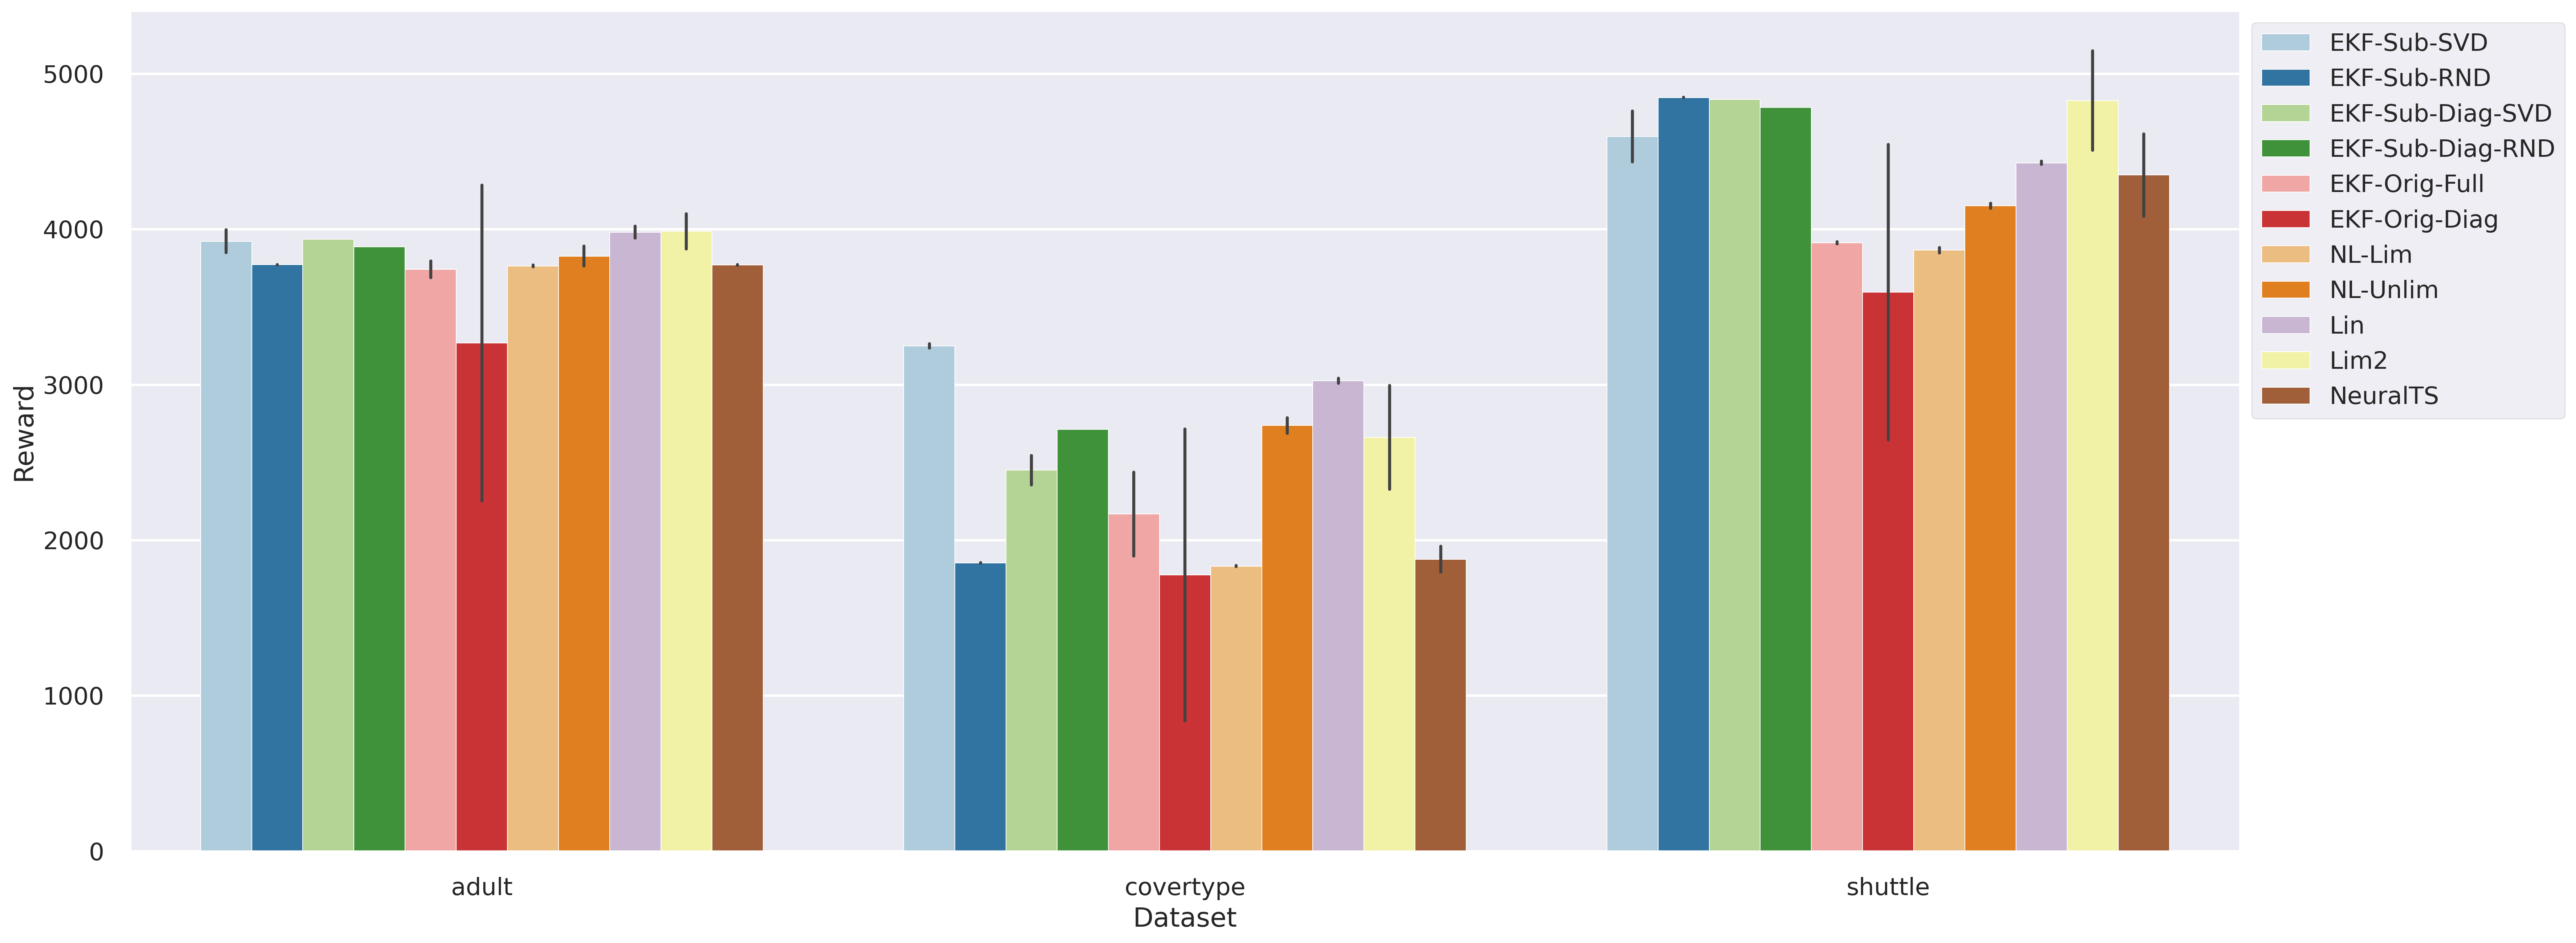

In [12]:
x, y = "Dataset", "Reward"
filename = "tabular_reward.png"
plot_figure(tabular_df, x, y, filename)

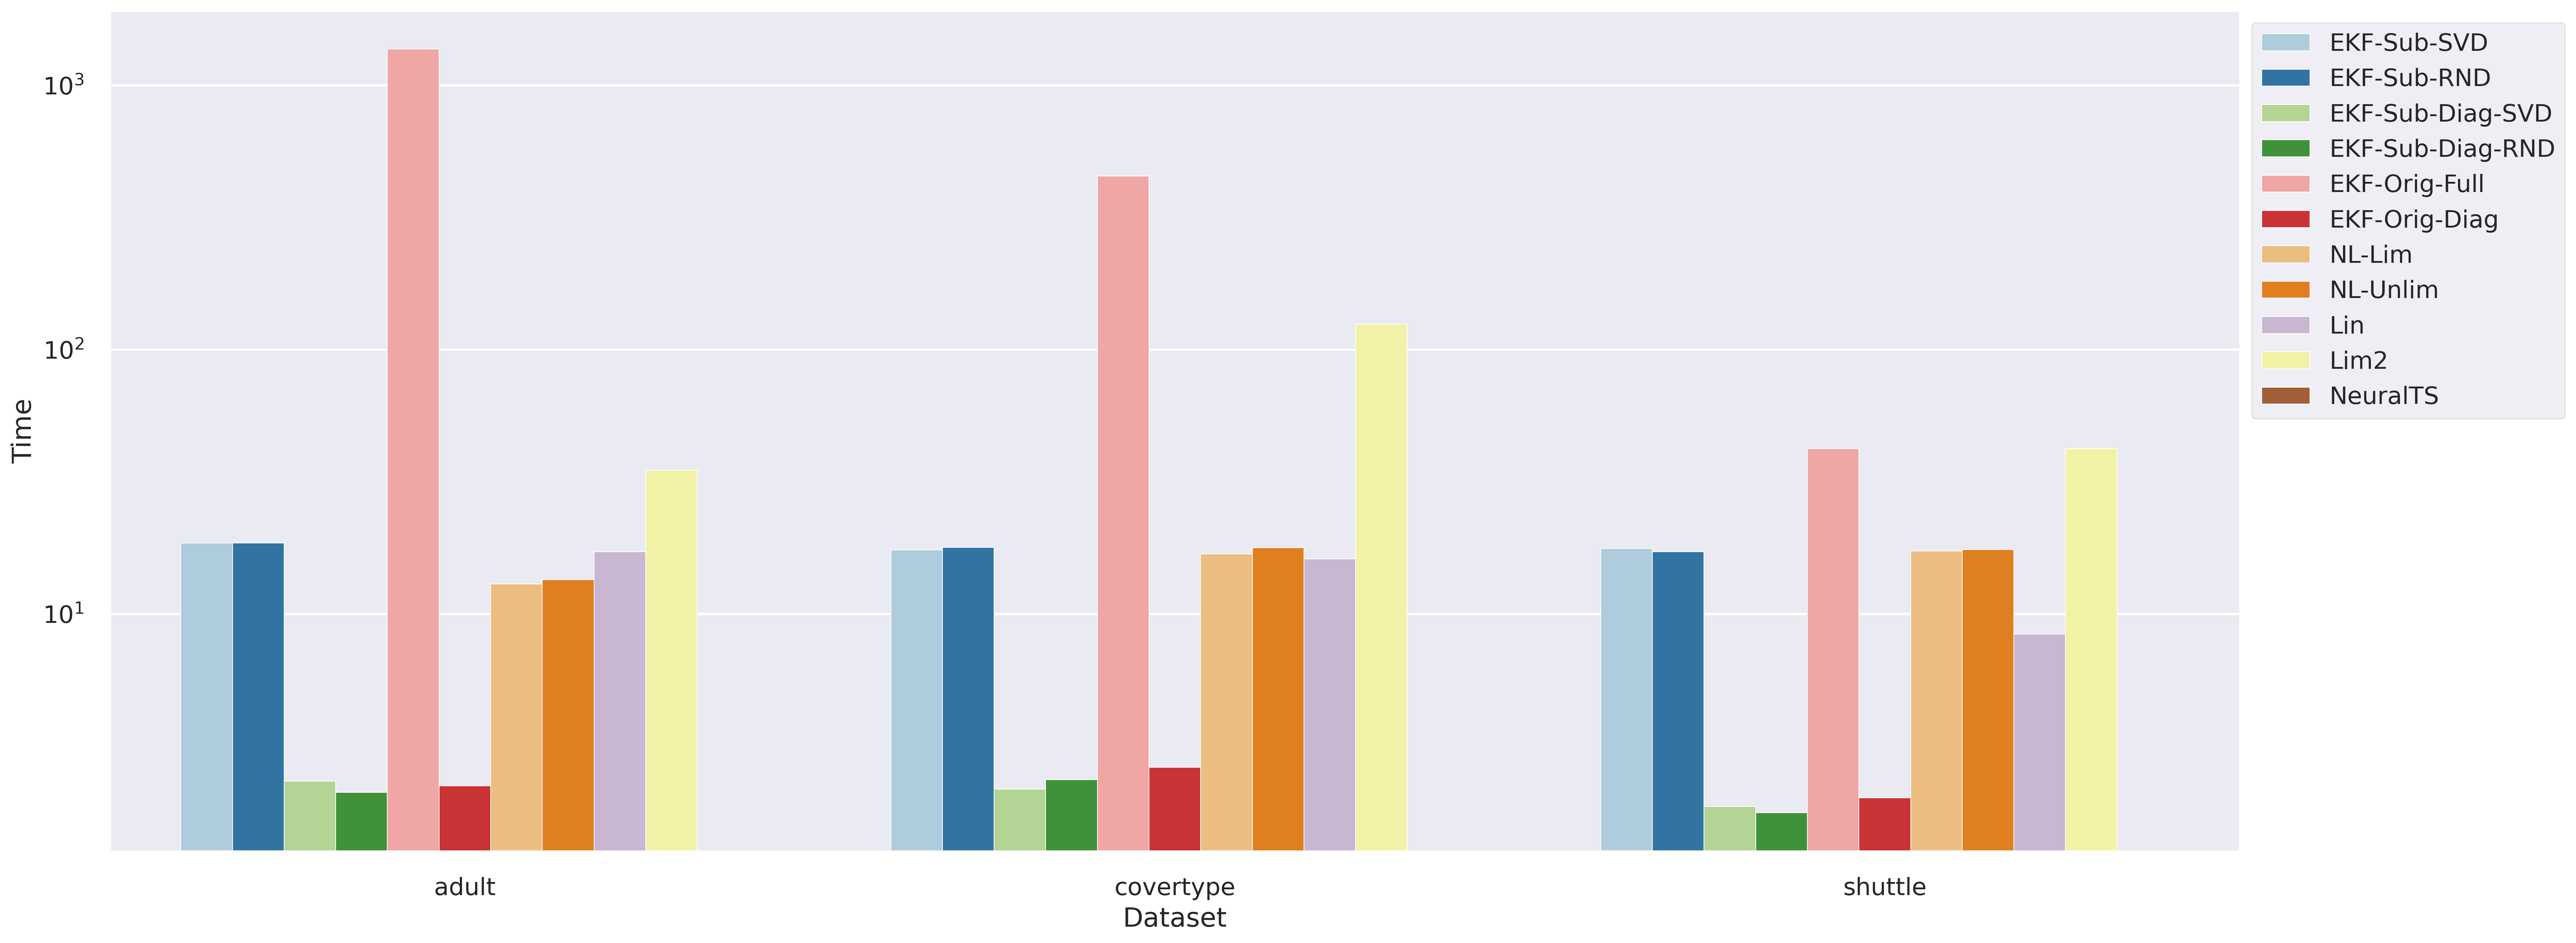

In [13]:
x, y = "Dataset", "Time"
filename = "tabular_time.png"
plot_figure(tabular_df, x, y, filename, log_scale=True)

# Run MNIST experiments

In [14]:
mnist_filename = f"./results/mnist_results_{datetime.timestamp(datetime.now())}.csv"
config = get_config(mnist_filename)
mnist_run.main(config)

Model : MLP1
	Bandit : Linear
		Expected Reward : 1448.70 ± 30.59
		Time : 500.7320384979248
	Bandit : Linear KF
		Expected Reward : 1453.10 ± 36.97
		Time : 280.39174365997314
	Bandit : Limited Neural Linear
		Expected Reward : 2856.50 ± 46.54
		Time : 19.53279137611389
	Bandit : Unlimited Neural Linear
		Expected Reward : 3003.80 ± 24.17
		Time : 21.206911087036133
	Bandit : EKF Subspace SVD
		Expected Reward : 4037.80 ± 14.98
		Time : 21.68575668334961
	Bandit : EKF Subspace RND
		Expected Reward : 3805.90 ± 4.53
		Time : 20.592533588409424
	Bandit : EKF Diagonal Subspace SVD
		Expected Reward : 3572.40 ± 10.20
		Time : 6.656015872955322
	Bandit : EKF Diagonal Subspace RND
		Expected Reward : 3206.00 ± 0.00
		Time : 5.374073505401611
	Bandit : EKF Orig Diagonal
		Expected Reward : 538.80 ± 0.40
		Time : 4.334591388702393
Model : MLP2
	Bandit : Limited Neural Linear
		Expected Reward : 2342.50 ± 45.64
		Time : 81.00956177711487
	Bandit : Unlimited Neural Linear
		Expected Reward : 28

# Plot results

In [15]:
dataset_name = "mnist"
mnist_filename = sorted(glob.glob(f"./results/mnist_results*.csv"))[-1]
mnist_df = read_data(dataset_name, mnist_filename)
mnist_rows = ['EKF-Sub-SVD', 'EKF-Sub-RND', 'EKF-Sub-Diag-SVD', 'EKF-Sub-Diag-RND', 'EKF-Orig-Diag', 'NL-Lim', 'NL-Unlim', 'Lin']
mnist_df = mnist_df[mnist_df['Method'].isin(mnist_rows)]

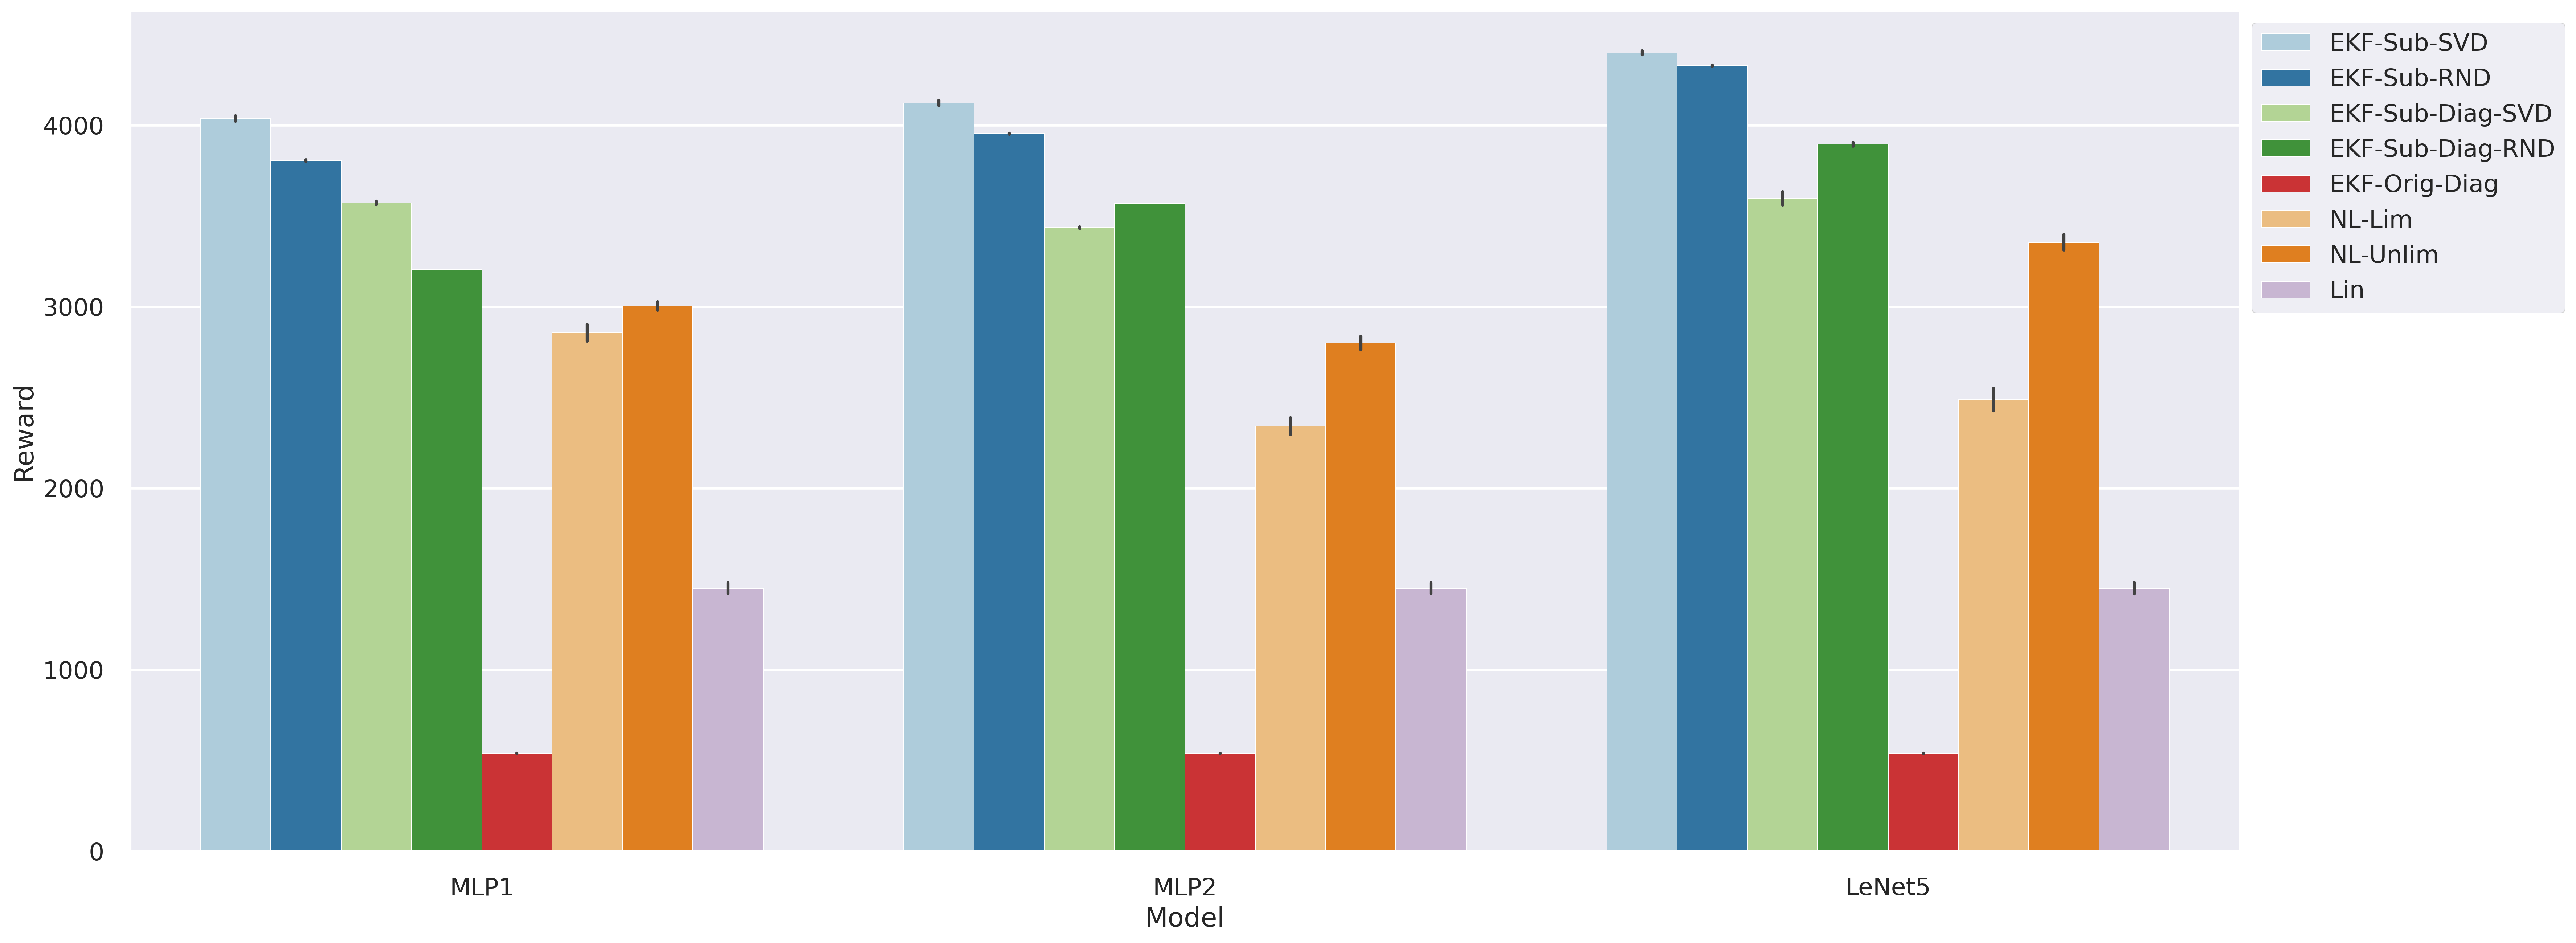

In [16]:
x, y = "Model", "Reward"
filename = f"{dataset_name}_{y.lower()}.png"
plot_figure(mnist_df, x, y, filename)

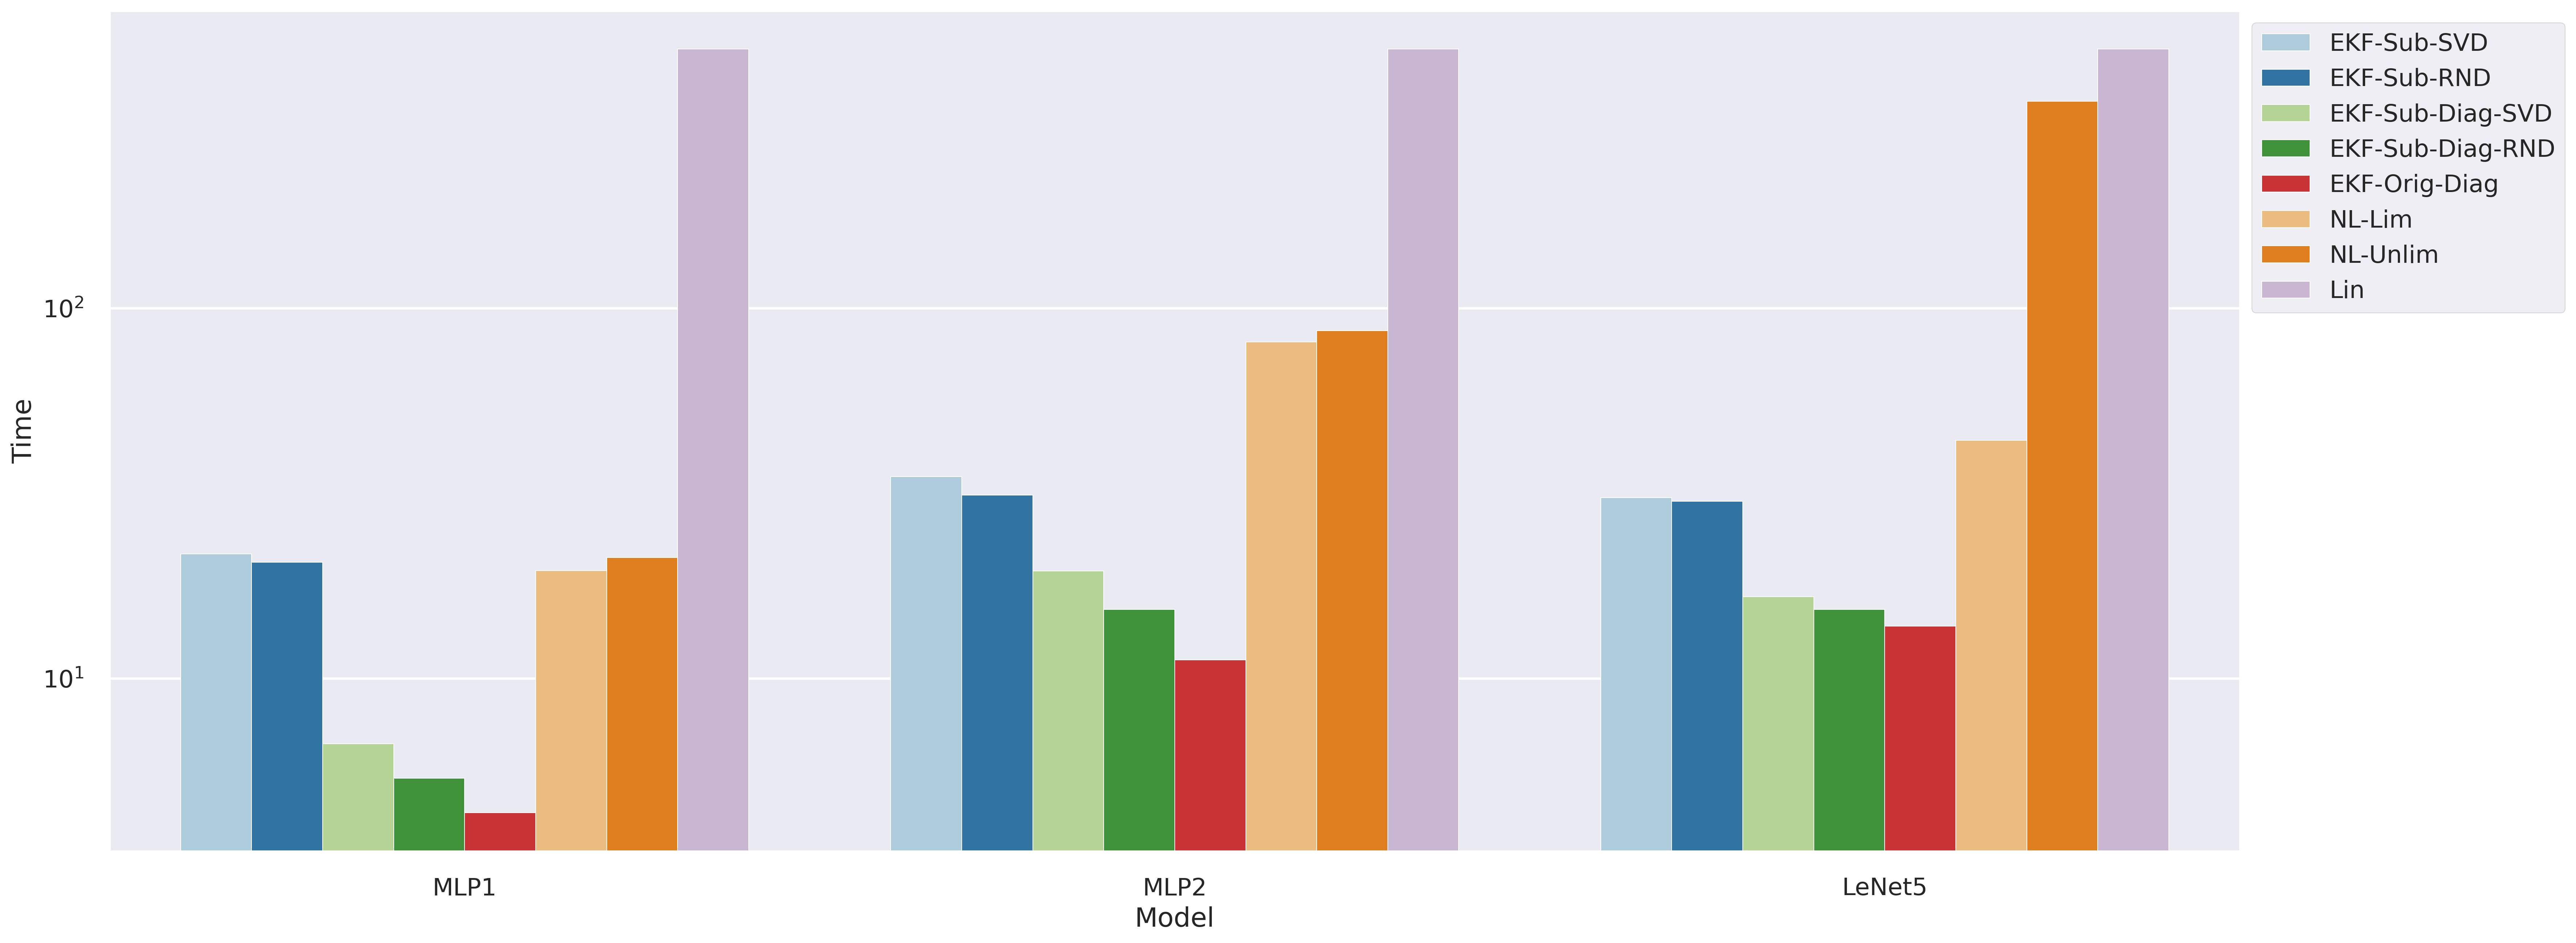

In [17]:
x, y = "Model", "Time"
filename = f"{dataset_name}_{y.lower()}.png"
plot_figure(mnist_df, x, y, filename, log_scale=True)

# Run movielens experiments

In [22]:
movielens_filename = f"./results/movielens_results_{datetime.timestamp(datetime.now())}.csv"
config = get_config(movielens_filename)
movielens_run.main(config)

Bandit : Linear
	Expected Reward : 2684.10 ± 42.98
	Time : 6.7297399044036865
Bandit : Linear KF
	Expected Reward : 2684.10 ± 42.98
	Time : 6.192228317260742
Bandit : Limited Neural Linear
	Expected Reward : 2049.70 ± 27.32
	Time : 9.848182916641235
Bandit : Unlimited Neural Linear
	Expected Reward : 2328.10 ± 21.45
	Time : 9.577424049377441
Bandit : EKF Subspace SVD
	Expected Reward : 3244.00 ± 1.73
	Time : 5.509897947311401
Bandit : EKF Subspace RND
	Expected Reward : 3240.90 ± 0.54
	Time : 5.490961790084839
Bandit : EKF Diagonal Subspace SVD
	Expected Reward : 3233.00 ± 0.00
	Time : 1.6845684051513672
Bandit : EKF Diagonal Subspace RND
	Expected Reward : 3232.00 ± 0.00
	Time : 1.4477789402008057
Bandit : EKF Orig Diagonal
	Expected Reward : 1710.70 ± 12.10
	Time : 1.3702571392059326
Bandit : Linear
	Expected Reward : 2684.10 ± 42.98
	Time : 6.731360197067261
Bandit : Linear KF
	Expected Reward : 2684.10 ± 42.98
	Time : 5.301701545715332
Bandit : Limited Neural Linear
	Expected Rewar

# Plot results

In [23]:
dataset_name = "movielens"
movielens_filename = sorted(glob.glob(f"./results/movielens_results*.csv"))[-1]
movielens_df = read_data(dataset_name, movielens_filename)
movielens_rows =  ['EKF-Sub-SVD', 'EKF-Sub-RND', 'EKF-Sub-Diag-SVD', 'EKF-Sub-Diag-RND', 'EKF-Orig-Diag', 'NL-Lim', 'NL-Unlim', 'Lin']
movielens_df = movielens_df[movielens_df['Method'].isin(movielens_rows)]

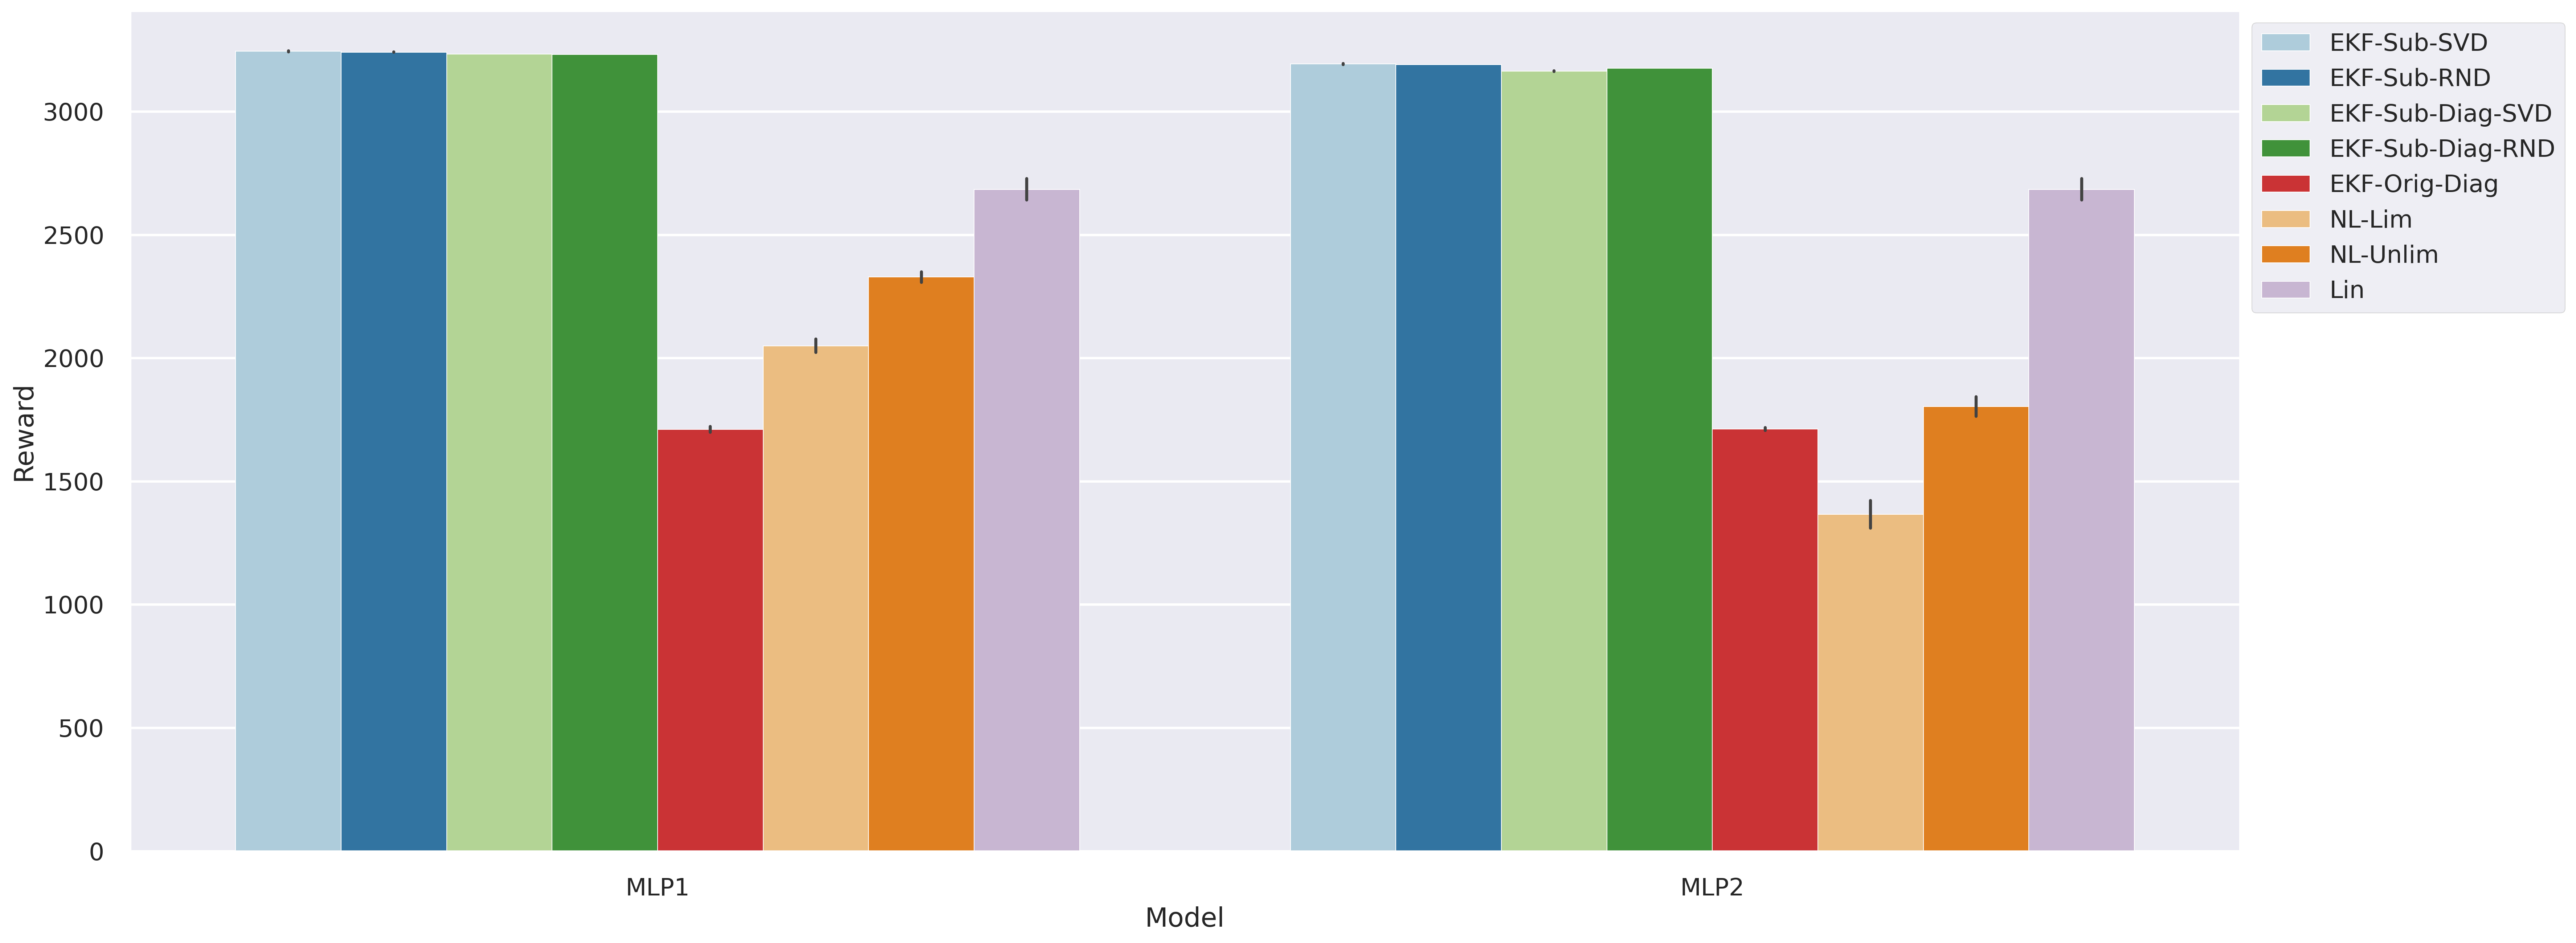

In [24]:
x, y = "Model", "Reward"
filename = f"{dataset_name}_{y.lower()}.png"
plot_figure(movielens_df, x, y, filename)

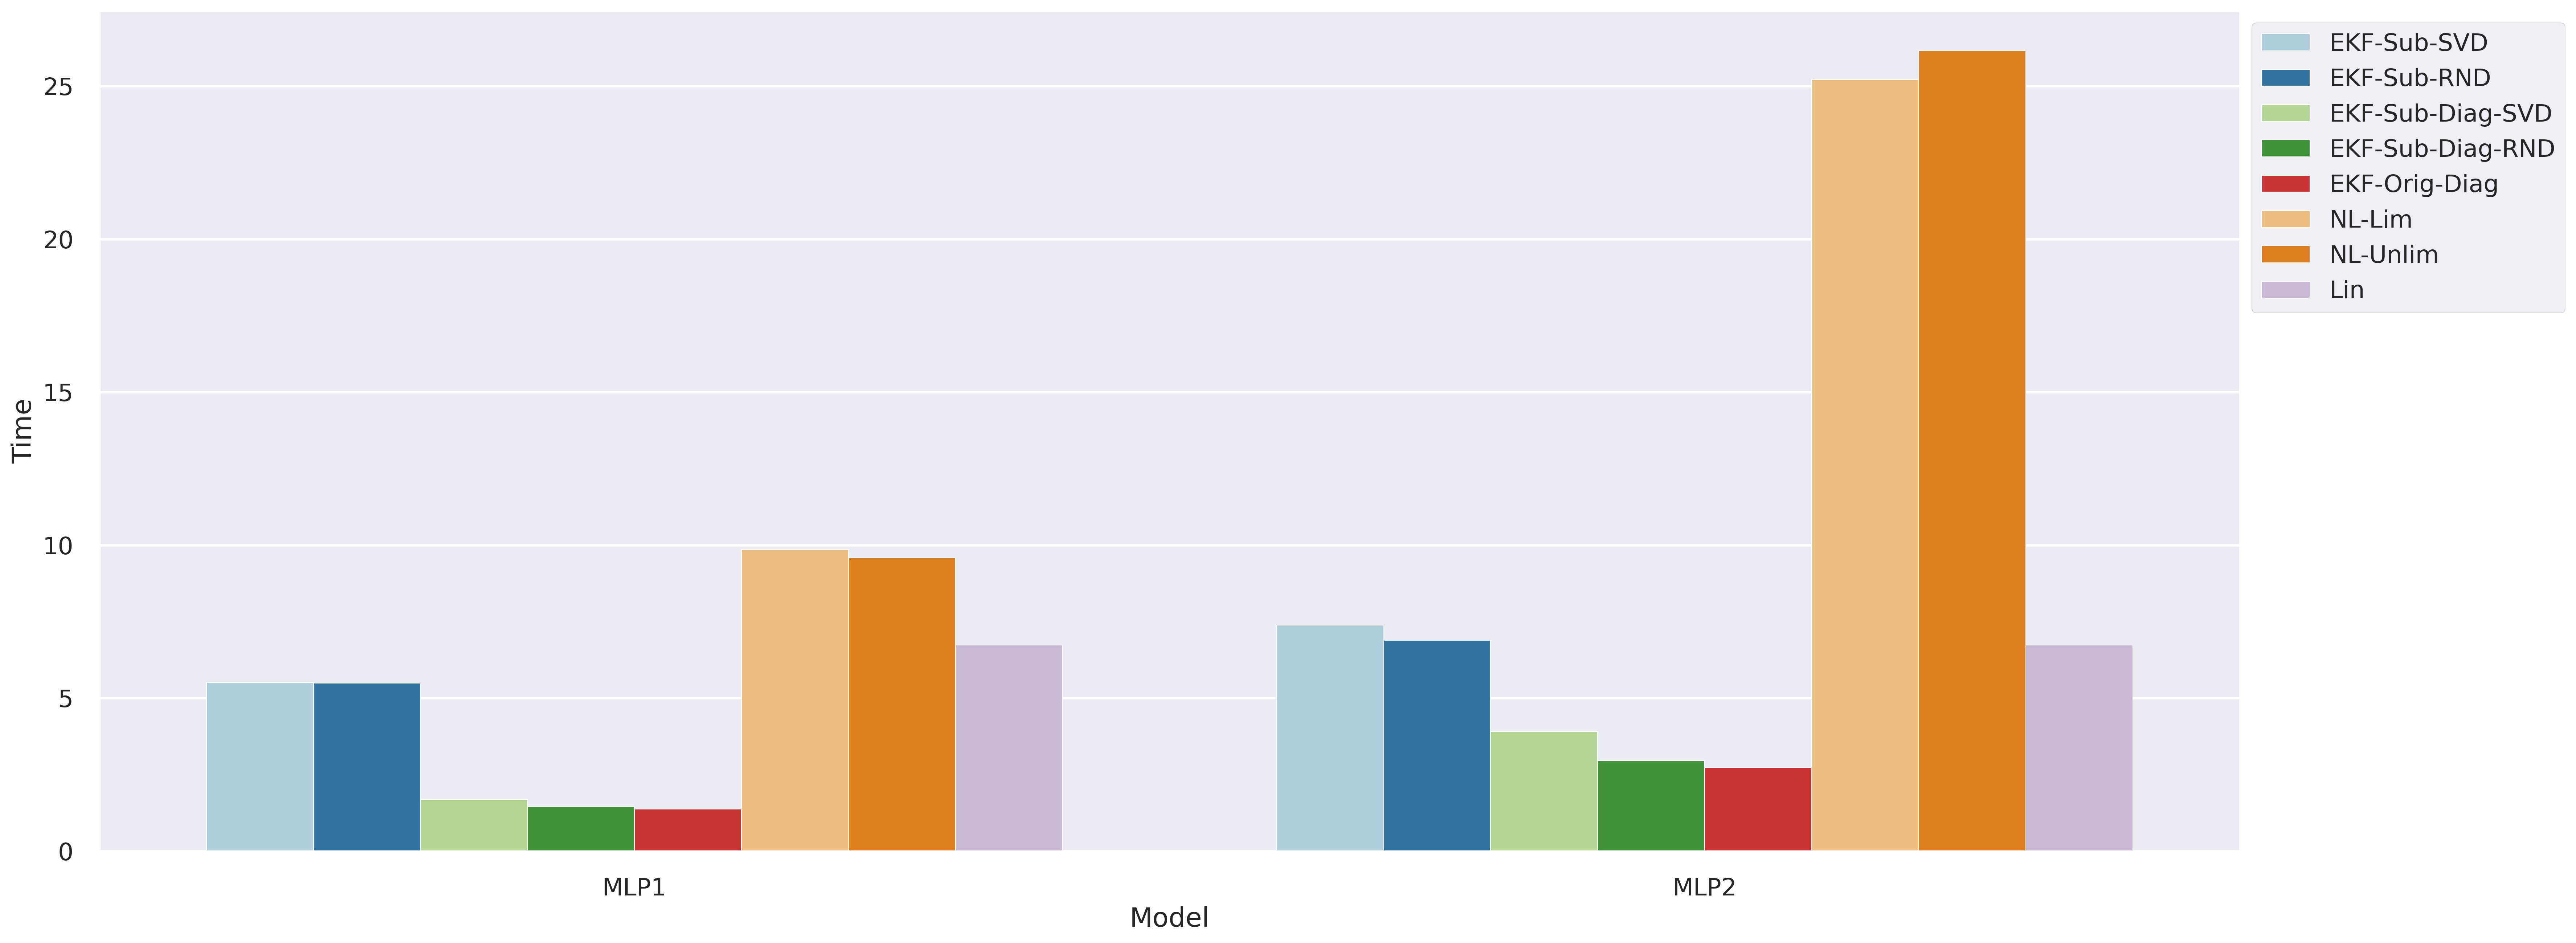

In [25]:
x, y = "Model", "Time"
filename = f"{dataset_name}_{y.lower()}.png"
plot_figure(movielens_df, x, y, filename)

# Run tabular subspace experiment

In [27]:
tabular_sub_filename = f"./results/tabular_subspace_results_{datetime.timestamp(datetime.now())}.csv"
config = get_config(tabular_sub_filename)
tabular_sub_run.main(config)

Environment :  shuttle
	Bandit : EKF Subspace SVD
		Expected Reward : 4466.50 ± 1.12
		Time : 2.804608106613159
	Bandit : EKF Subspace RND
		Expected Reward : 4711.90 ± 0.30
		Time : 2.1916263103485107
	Bandit : EKF Subspace SVD
		Expected Reward : 4080.90 ± 0.94
		Time : 2.1420609951019287
	Bandit : EKF Subspace RND
		Expected Reward : 4372.50 ± 32.35
		Time : 2.2466847896575928
	Bandit : EKF Subspace SVD
		Expected Reward : 4125.60 ± 1.11
		Time : 2.1361966133117676
	Bandit : EKF Subspace RND
		Expected Reward : 4609.20 ± 0.60
		Time : 2.212956190109253
	Bandit : EKF Subspace SVD
		Expected Reward : 4371.40 ± 0.49
		Time : 2.250501871109009
	Bandit : EKF Subspace RND
		Expected Reward : 4741.90 ± 0.54
		Time : 2.3078036308288574
	Bandit : EKF Subspace SVD
		Expected Reward : 4787.30 ± 1.55
		Time : 2.311060905456543
	Bandit : EKF Subspace RND
		Expected Reward : 4299.30 ± 68.41
		Time : 2.4068565368652344
	Bandit : EKF Subspace SVD
		Expected Reward : 4781.40 ± 2.91
		Time : 2.367562

## Plot results

In [147]:
def plot_subspace_figure(df, filename):
  sns.set_palette("tab10")
  df = df.reset_index().drop(columns=["index"])
  fig, ax = plt.subplots(figsize=(12, 8))
  sns.lineplot(x="Subspace Dim", y="Reward", hue="Method", marker="o", data=df)
  lines, labels = ax.get_legend_handles_labels()
  
  for line, method in zip(lines, labels):
    data = df[df["Method"]==method]
    color = line.get_c()
    ax.fill_between(data["Subspace Dim"],  data["Reward"] -  data["Std"],  data["Reward"] + data["Std"], color=color, alpha=0.3)
   
  ax.set_ylabel("Reward", fontsize=16)
  plt.setp(ax.get_xticklabels(), fontsize=16) 
  plt.setp(ax.get_yticklabels(), fontsize=16) 
  ax.set_xlabel("Subspace Dimension(d)", fontsize=16)
  dataset = df.iloc[0]["Dataset"]
  ax.set_title(f"{dataset.title()} - Subspace Dim vs. Reward", fontsize=18)
  legend = ax.legend(loc="lower right", prop={'size': 16},frameon=1)
  frame = legend.get_frame()
  frame.set_color('white')
  frame.set_alpha(0.6)
  plt.savefig(filename, dpi=300)
  plt.show()

In [28]:
tabular_sub_df = pd.read_csv(sorted(glob.glob("./results/tabular_subspace_results*.csv"))[-1])

In [34]:
def plot_subspace_figure(df, filename=None):
  df = df.reset_index().drop(columns=["index"])
  plt.style.use("seaborn-darkgrid")
  fig, ax = plt.subplots(figsize=(12, 8))
  sns.lineplot(x="Subspace Dim", y="Reward", hue="Method", marker="o", data=df)
  lines, labels = ax.get_legend_handles_labels()
  for line, method in zip(lines, labels):
    data = df[df["Method"]==method]
    color = line.get_c()
    ax.fill_between(data["Subspace Dim"],  data["Reward"] -  data["Std"],  data["Reward"] + data["Std"], color=color, alpha=0.3)
   
  ax.set_ylabel("Reward", fontsize=16)
  plt.setp(ax.get_xticklabels(), fontsize=16) 
  plt.setp(ax.get_yticklabels(), fontsize=16) 
  ax.set_xlabel("Subspace Dimension(d)", fontsize=16)
  dataset = df.iloc[0]["Dataset"]
  ax.set_title(f"{dataset.title()} - Subspace Dim vs. Reward", fontsize=18)
  legend = ax.legend(loc="lower right", prop={'size': 16},frameon=1)
  frame = legend.get_frame()
  frame.set_color('white')
  frame.set_alpha(0.6)
  # if filename is None:
  #   plt.savefig(f"bandits/figures/{dataset}_sub_reward.png")
  # else:
  #   plt.savefig(f"bandits/figures/{filename}")
  plt.show()

## Shuttle

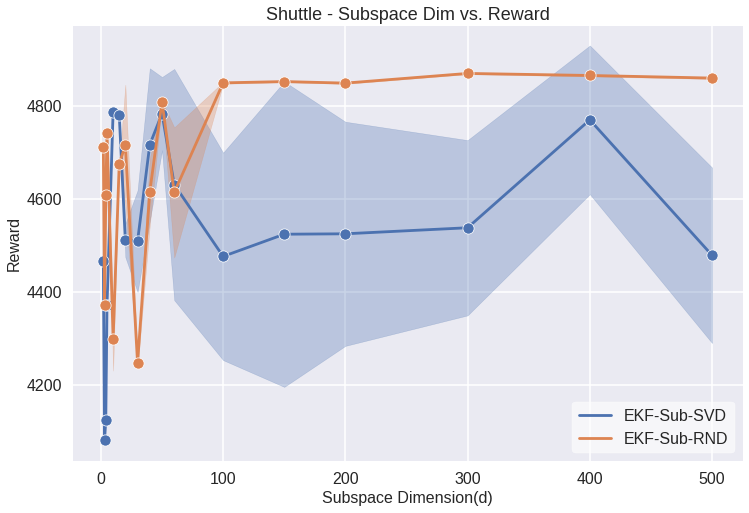

In [35]:
dataset_name = "shuttle"
filename = f"{dataset_name}_sub.png"
shuttle = tabular_sub_df[tabular_sub_df["Dataset"]==dataset_name]
plot_subspace_figure(shuttle, filename)

## Adult

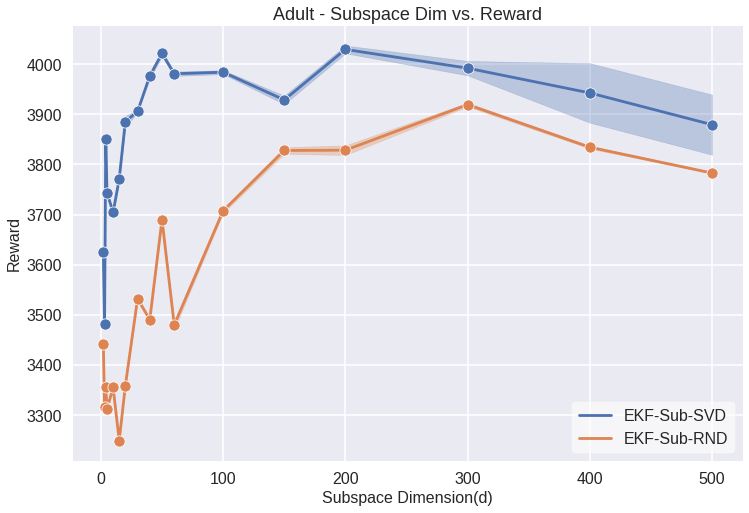

In [36]:
dataset_name = "adult"
filename = f"{dataset_name}_sub.png"
adult = tabular_sub_df[tabular_sub_df["Dataset"]==dataset_name]
plot_subspace_figure(adult, filename)

## Covertype

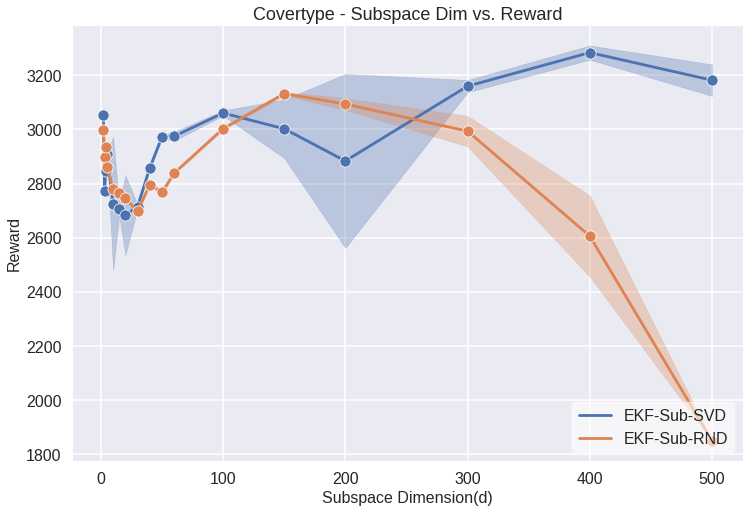

In [37]:
dataset_name = "covertype"
filename = f"{dataset_name}_sub.png"
covertype = tabular_sub_df[tabular_sub_df["Dataset"]==dataset_name]
plot_subspace_figure(covertype, filename)